source: https://sofifa.com/

# Importy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import re

# Wczytywanie danych i pre-processing

## Czyszczenie danych

In [2]:
df = pd.read_csv('Fifa2022-Males.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 104 entries, sofifa_id to gk
dtypes: float64(18), int64(44), object(42)
memory usage: 15.3+ MB


In [3]:
df.columns.tolist()

['sofifa_id',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'club_name',
 'league_name',
 'league_level',
 'club_position',
 'club_jersey_number',
 'club_loaned_from',
 'club_joined',
 'club_contract_valid_until',
 'nationality_id',
 'nationality_name',
 'nation_team_id',
 'nation_position',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'moveme

In [4]:
main_position = []

position_info = {
    "RF":"Forward",
    "CF":"Forward",
    "LF":"Forward",
    "RS":"Forward",
    "ST":"Forward",
    "LS":"Forward",
    "LW":"Forward",
    "RW":"Forward",
    "RDM":"Middle",
    "RCDM":"Middle",
    "CDM":"Middle",
    "LCDM":"Middle",
    "LDM":"Middle",
    "RWM":"Middle",
    "RM":"Middle",
    "RCM":"Middle",
    "CM":"Middle",
    "LCM":"Middle",
    "LM":"Middle",
    "LWM":"Middle",
    "RAM":"Middle",
    "RCAM":"Middle",
    "CAM":"Middle",
    "LCAM":"Middle",
    "LAM":"Middle",
    "SW":"Back",
    "RWB":"Back",
    "RB":"Back",
    "RCB":"Back",
    "CB":"Back",
    "LCB":"Back",
    "LB":"Back",
    "LWB":"Back",
    "GK":"Goalkeeper"
}

for i in range(len(df)):
    if(df['club_position'][i] in position_info):
        main_position.append(position_info.get(df['club_position'][i]))
    elif (df['nation_position'][i] in position_info):
        main_position.append(position_info.get(df['nation_position'][i]))
    else:
        position_list = df['player_positions'][i].replace(" ", "").split(",")
        temp = []
        for j in range(len(position_list)):
            temp.append(position_info.get(position_list[j]))
        main_position.append(max(set(temp), key = temp.count))

In [5]:
df = df.drop(columns=[
    'sofifa_id',
    'long_name',
    'dob',  # date of birth
    'club_team_id',
    'club_position',
    'club_jersey_number',
    'club_loaned_from',
    'club_joined',
    'club_contract_valid_until',
    'nationality_id',
    'nation_team_id',
    'nation_position',
    'nation_jersey_number',
    'work_rate',
    'body_type',
    'real_face',
    'player_tags',
    'player_traits',
    'preferred_foot',
]);

In [6]:
def nan_columns(df: DataFrame, head: int = 10):  # columns with quantities of NA descending
    print(df.isna().sum().sort_values(ascending=False).head(head))

In [7]:
nan_columns(df, head=18)

goalkeeping_speed     17107
passing                2132
shooting               2132
pace                   2132
defending              2132
physic                 2132
dribbling              2132
release_clause_eur     1176
rw                      326
lw                      326
value_eur                74
league_name              61
league_level             61
club_name                61
wage_eur                 61
rs                        0
lf                        0
cf                        0
dtype: int64


In [8]:
df = df.dropna(subset=['value_eur'])  # no data about value
df = df.drop(columns=['pace', 'defending', 'dribbling', 'passing', 'shooting', 'physic',
                      'goalkeeping_speed'])  # incompatible data (from 2 different versions, complementary nan's)])  
df['release_clause_eur'] = df['release_clause_eur'].fillna(0)  # probably no release clause
df['lw'] = df['lw'].fillna(df['lf'])  # position lw is closest to lf
df['rw'] = df['rw'].fillna(df['rf'])  # position rw is closest to rf

# TODO zmapować 'players_positions' do 'players_position' (jednej z czterech)

In [9]:
nan_columns(df, head=3)

short_name                 0
goalkeeping_positioning    0
cf                         0
dtype: int64


In [10]:
df = df.drop(columns=[ # usunięcie kolumn które znaczoąco wpływają na ocenę klasyfikatora
    'wage_eur',
    'release_clause_eur',
    'overall',
    'potential',
]);

In [11]:
cols_dict = {
    'descriptive': ['short_name',
                    'player_positions',  # TODO podmienić na players_position jak będzie gotowe
                    'club_name',
                    'league_name',
                    'nationality_name',
                    ],
   #'score': ['overall',
   #          'potential'],
    'attacking': ['attacking_crossing',
                  'attacking_finishing',
                  'attacking_heading_accuracy',
                  'attacking_short_passing',
                  'attacking_volleys'],
    'skill': ['skill_dribbling',
              'skill_curve',
              'skill_fk_accuracy',
              'skill_long_passing',
              'skill_ball_control'],
    'movement': ['movement_acceleration',
                 'movement_sprint_speed',
                 'movement_agility',
                 'movement_reactions',
                 'movement_balance'],
    'power': ['power_shot_power',
              'power_jumping',
              'power_stamina',
              'power_strength',
              'power_long_shots'],
    'mentality': ['mentality_aggression',
                  'mentality_interceptions',
                  'mentality_positioning',
                  'mentality_vision',
                  'mentality_penalties',
                  'mentality_composure'],
    'defending': ['defending_marking_awareness',
                  'defending_standing_tackle',
                  'defending_sliding_tackle'],
    'goalkeeping': ['goalkeeping_diving',
                    'goalkeeping_handling',
                    'goalkeeping_kicking',
                    'goalkeeping_positioning',
                    'goalkeeping_reflexes'],
    'position': [      'ls' ,'st' ,'rs',
                 'lw' ,'lf' ,'cf' ,'rf', 'rw',
                       'lam','cam','ram',
                 'lm' ,'lcm','cm' ,'rcm', 'rm',  # arrangement of positions
                 'lwb','ldm','cdm','rdm','rwb',
                 'lb', 'lcb','cb' ,'rcb', 'rb',
                             'gk']
}
cols_dict['features'] = [cols_dict[feature] for feature in cols_dict.keys()]
cols_dict['features'] = sum(cols_dict['features'], [])  # flaten list of lists
cols_dict['all'] = df.columns.to_list()
columns = cols_dict['all']
cols_dict['others'] = list(set(cols_dict['all']) - set(cols_dict['features']))
cols_dict['others'].sort()
cols_dict['others']

['age',
 'height_cm',
 'international_reputation',
 'league_level',
 'skill_moves',
 'value_eur',
 'weak_foot',
 'weight_kg']

In [12]:
df[cols_dict['position']] = df[cols_dict['position']].map(
    lambda datum: sum([int(x) for x in re.split(r'[+-]', datum)]) if isinstance(datum, str) 
    else int(datum))  # including +- for 'international_reputation'

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   short_name                   19165 non-null  object 
 1   player_positions             19165 non-null  object 
 2   value_eur                    19165 non-null  float64
 3   age                          19165 non-null  int64  
 4   height_cm                    19165 non-null  int64  
 5   weight_kg                    19165 non-null  int64  
 6   club_name                    19165 non-null  object 
 7   league_name                  19165 non-null  object 
 8   league_level                 19165 non-null  float64
 9   nationality_name             19165 non-null  object 
 10  weak_foot                    19165 non-null  int64  
 11  skill_moves                  19165 non-null  int64  
 12  international_reputation     19165 non-null  int64  
 13  attacking_crossing   

## Wizualizacja wyczyszczonych danych

In [14]:
df[cols_dict['descriptive']].describe()[1:]

,short_name,player_positions,club_name,league_name,nationality_name
unique,18076,674,701,55,163
top,J. Rodríguez,CB,Paris Saint-Germain,USA Major League Soccer,England
freq,13,2408,33,771,1717


In [15]:
df[cols_dict['others']].describe()[1:]

,age,height_cm,international_reputation,league_level,skill_moves,value_eur,weak_foot,weight_kg
mean,25.190034,181.290008,1.093817,1.354239,2.351944,2.850452e+06,2.945682,74.930342
std,4.727515,6.862654,0.370406,0.747572,0.767516,7.613700e+06,0.671623,7.066639
min,16.000000,155.000000,1.000000,1.000000,1.000000,9.000000e+03,1.000000,49.000000
25%,21.000000,176.000000,1.000000,1.000000,2.000000,4.750000e+05,3.000000,70.000000
50%,25.000000,181.000000,1.000000,1.000000,2.000000,9.750000e+05,3.000000,75.000000
75%,29.000000,186.000000,1.000000,1.000000,3.000000,2.000000e+06,3.000000,80.000000
max,43.000000,206.000000,5.000000,5.000000,5.000000,1.940000e+08,5.000000,110.000000


In [16]:
def show_boxplot(df: DataFrame, columns: str):
    if columns in cols_dict.keys():
        labels = cols_dict[columns]
        labels = [label.removeprefix(columns + '_') for label in labels]
    else:
        labels = None
    
    leftmargin = 0.5
    rightmargin = 0.3
    categorysize = 0.1

    n = df.shape[1]

    figwidth = leftmargin + rightmargin + (n+1)*categorysize

    fig, ax = plt.subplots(figsize=(figwidth, 6))
    fig.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth,
                        top=0.94, bottom=0.1)
    ax.boxplot(df[cols_dict[columns]], labels=labels)
    plt.title(columns)
    plt.show()

dict_keys(['descriptive', 'attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping', 'position', 'features', 'all', 'others'])


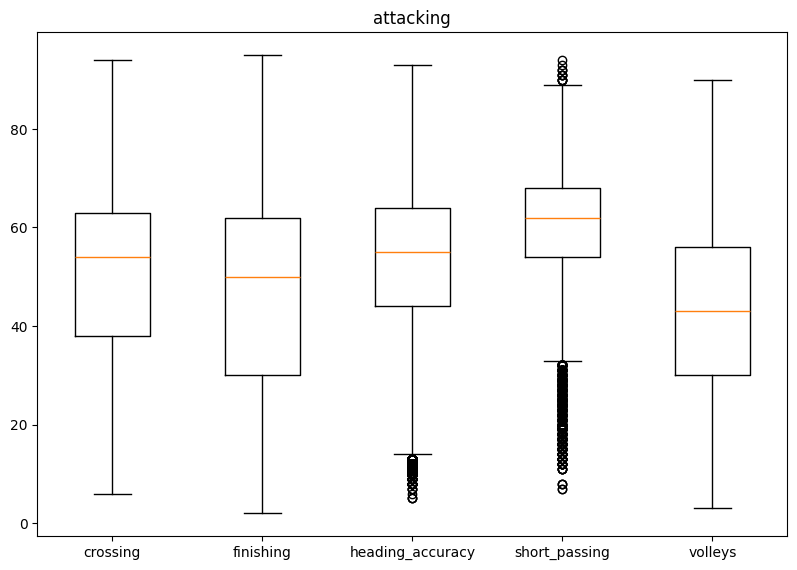

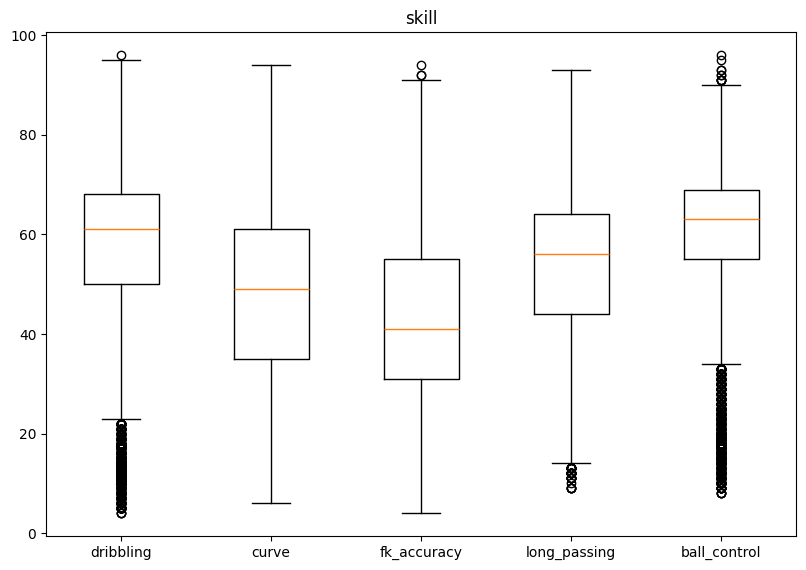

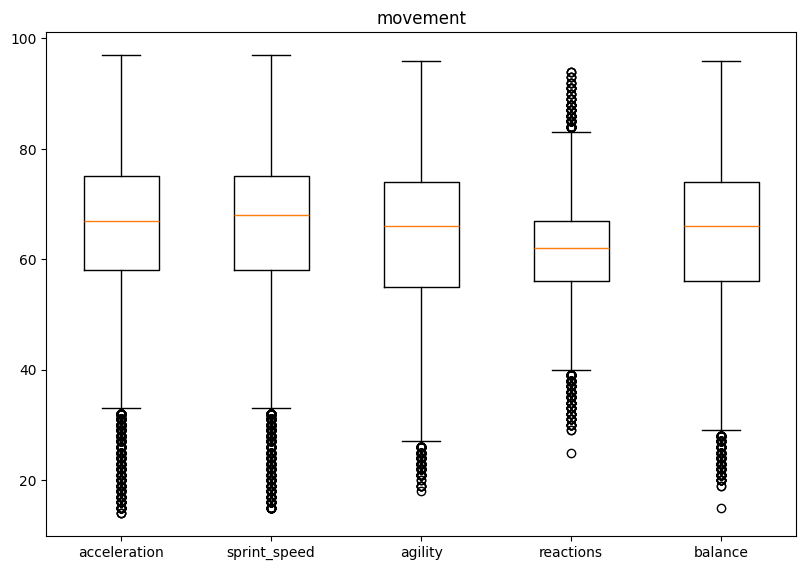

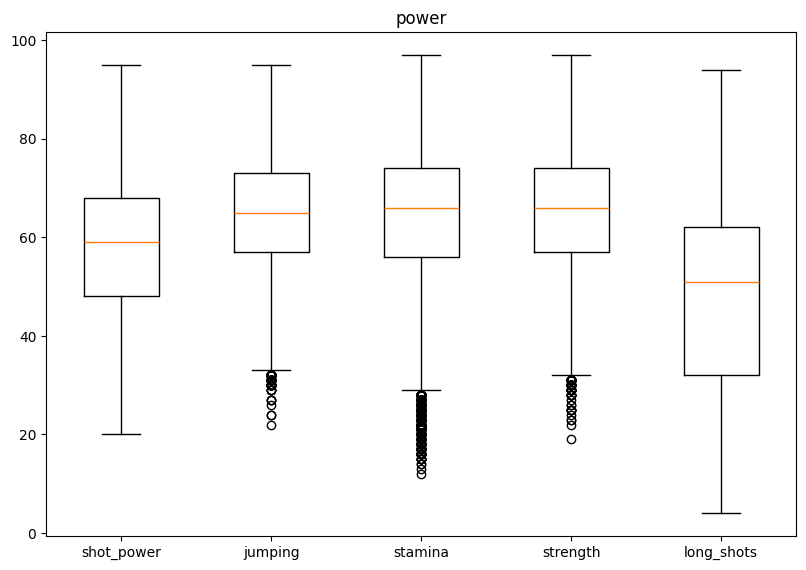

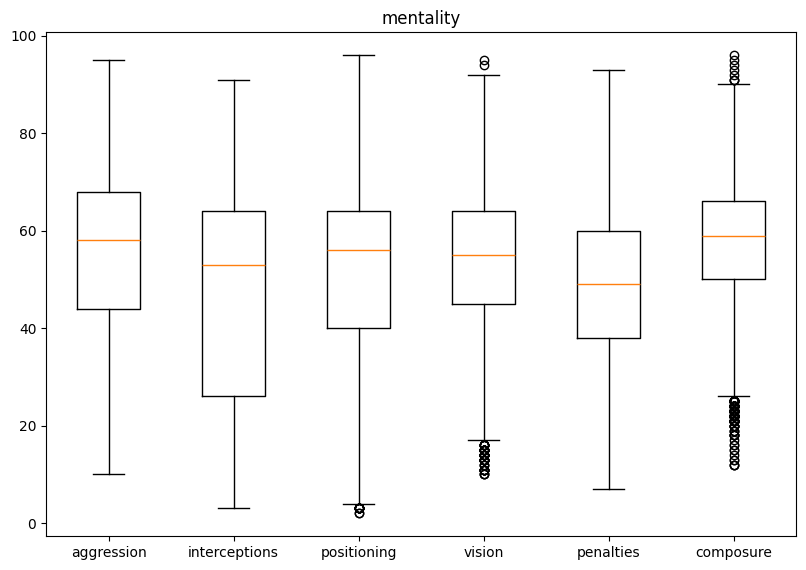

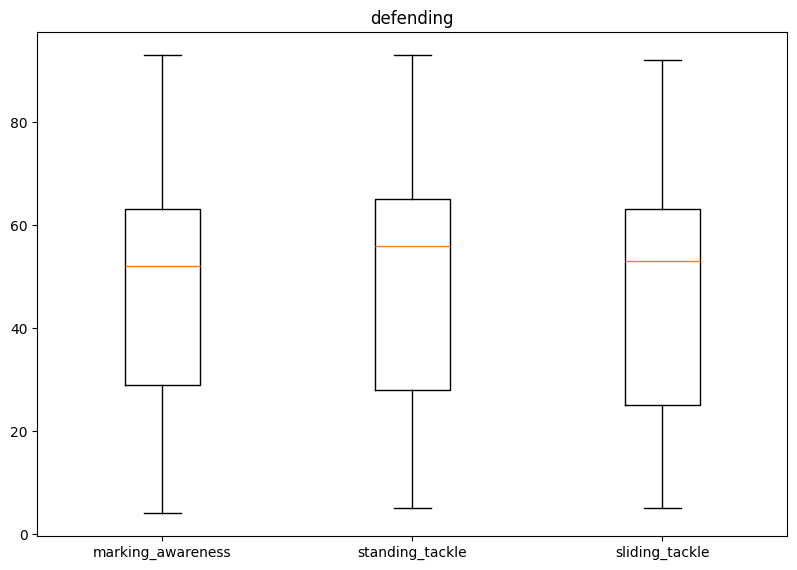

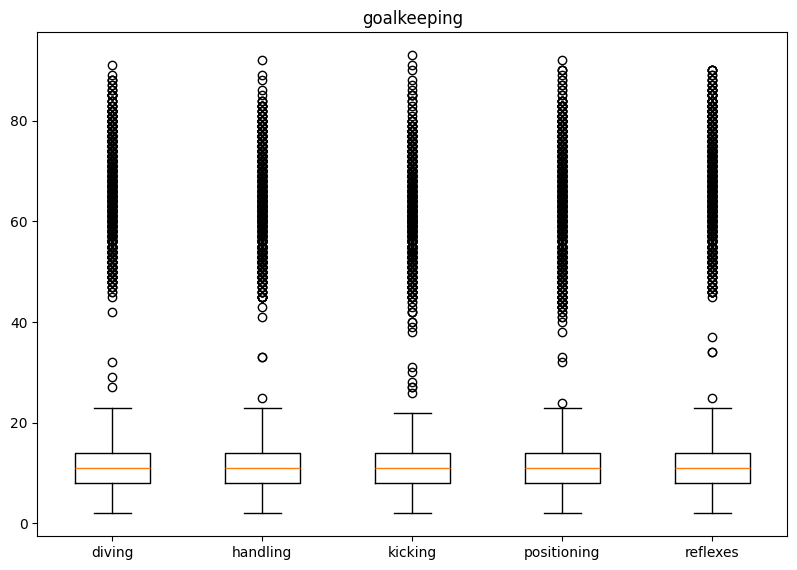

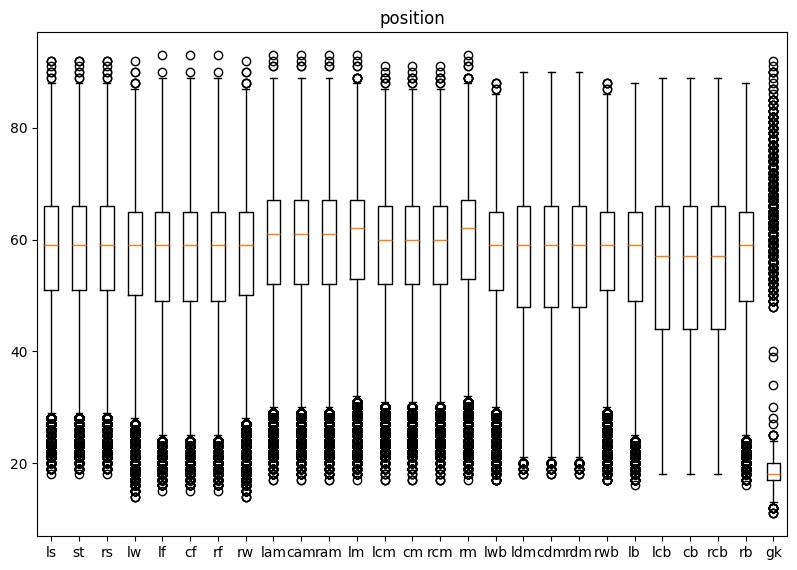

In [17]:
print(cols_dict.keys())
for key in cols_dict.keys():
    if key not in ['descriptive', 'features', 'all', 'others']:
        show_boxplot(df, key)

# Standaryzacja

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
df_stand = df.copy()

col_drop_standard = [
    'short_name',
    'player_positions',
    'club_name',
    'league_name',
    'nationality_name',
]
df_stand =  df_stand.drop(columns = col_drop_standard)

df_stand.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19165 entries, 0 to 19238
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   value_eur                    19165 non-null  float64
 1   age                          19165 non-null  int64  
 2   height_cm                    19165 non-null  int64  
 3   weight_kg                    19165 non-null  int64  
 4   league_level                 19165 non-null  float64
 5   weak_foot                    19165 non-null  int64  
 6   skill_moves                  19165 non-null  int64  
 7   international_reputation     19165 non-null  int64  
 8   attacking_crossing           19165 non-null  int64  
 9   attacking_finishing          19165 non-null  int64  
 10  attacking_heading_accuracy   19165 non-null  int64  
 11  attacking_short_passing      19165 non-null  int64  
 12  attacking_volleys            19165 non-null  int64  
 13  skill_dribbling      

In [20]:
scaler = StandardScaler()
data_1 = df_stand.iloc[:,:]
data_stand = scaler.fit_transform(data_1)
data_stand

array([[ 9.87056351,  1.86359972, -1.64518018, ..., -0.09175446,
         0.60450243, -0.08375154],
       [15.32140647,  1.44053345,  0.54062014, ...,  0.58798046,
         0.60450243, -0.08375154],
       [ 5.53615826,  2.28666598,  0.83206018, ...,  0.11216602,
         0.53345973, -0.01738129],
       ...,
       [-0.36125978, -0.886331  , -0.47942001, ..., -0.49959541,
        -0.46113814, -0.61471362],
       [-0.35994632, -1.30939726, -1.20802011, ..., -1.79109176,
        -1.52677872, -0.41560284],
       [-0.35994632, -1.30939726, -2.08234024, ..., -0.77148938,
        -0.60322355, -0.34923258]])

# Wyznaczanie składowych głównych

In [21]:
from sklearn.decomposition import PCA

In [22]:
index_pca = [
 #'overall',
 #'potential',
 'value_eur',
 #'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation', 
 #'release_clause_eur',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',  
 'goalkeeping_diving',
 'goalkeeping_handling', 
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'ls',
 'st',
 'rs',
 'lw',
 'lf',
 'cf',
 'rf',
 'rw',
 'lam',
 'cam',
 'ram',
 'lm',
 'lcm',
 'cm',
 'rcm', 
 'rm',
 'lwb',
 'ldm',
 'cdm',
 'rdm' ,
 'rwb', 
 'lb',
 'lcb', 
 'cb',
 'rcb',
 'rb',
 'gk'
]

In [23]:
pca = PCA()
pca_data = pca.fit_transform(data_stand)
n_components = len(pca.components_)
pca_cols = [f'PC{x+1}' for x in range(n_components)]
df_pca_componenets = pd.DataFrame(data=np.transpose(pca.components_), columns=pca_cols, index = index_pca)
df_pca_componenets.abs().sort_values(by='PC1',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
lcm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,...,2.889280e-01,5.578142e-02,8.009889e-02,4.287627e-03,2.202395e-03,1.378089e-02,7.677782e-04,2.040931e-03,1.367755e-16,9.247426e-17
rcm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,...,1.444640e-01,2.789071e-02,4.004944e-02,2.143814e-03,1.101198e-03,6.890446e-03,3.838891e-04,1.020465e-03,7.067430e-01,2.267867e-02
cm,0.151049,0.001376,0.051643,0.044389,0.057360,0.020187,0.019891,0.033589,0.026371,0.064200,...,1.444640e-01,2.789071e-02,4.004944e-02,2.143814e-03,1.101198e-03,6.890446e-03,3.838891e-04,1.020465e-03,7.067430e-01,2.267867e-02
lm,0.149650,0.065638,0.004215,0.019791,0.020403,0.002560,0.009764,0.065119,0.037795,0.022374,...,3.007623e-02,5.077305e-02,8.627202e-02,3.912561e-01,1.602641e-01,6.997425e-02,1.441991e-01,5.176945e-01,2.112185e-16,1.660073e-16
rm,0.149650,0.065638,0.004215,0.019791,0.020403,0.002560,0.009764,0.065119,0.037795,0.022374,...,3.007623e-02,5.077305e-02,8.627202e-02,3.912561e-01,1.602641e-01,6.997425e-02,1.441991e-01,5.176945e-01,2.273684e-16,9.306730e-17
skill_ball_control,0.147965,0.037445,0.001415,0.031102,0.012738,0.049336,0.002366,0.016928,0.012672,0.022133,...,4.859584e-17,1.120023e-16,2.432604e-16,7.211413e-17,6.634549e-17,2.715822e-16,6.933590e-17,1.634690e-17,9.496107e-18,1.197432e-17
ram,0.147744,0.081691,0.032037,0.012072,0.014025,0.012551,0.011507,0.049373,0.026894,0.038543,...,3.330480e-01,1.779139e-01,9.517726e-02,4.921984e-02,2.587496e-01,6.282252e-02,5.197010e-01,2.026712e-01,6.036998e-16,4.419881e-16


In [24]:
df_pca_componenets.abs().sort_values(by='PC2',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
defending_sliding_tackle,0.084976,0.258602,0.053252,0.102452,0.050891,0.025947,0.021764,0.000116,0.008514,0.005378,...,5.351486e-17,6.036920e-17,8.770078e-17,3.998183e-17,7.633118e-18,1.025854e-17,2.770228e-17,6.997919e-17,1.991400e-17,7.839673e-20
defending_standing_tackle,0.090044,0.253757,0.041743,0.094096,0.060666,0.031994,0.027463,0.001711,0.009659,0.000165,...,5.307434e-17,1.449006e-16,1.370022e-18,3.307246e-17,1.461953e-17,2.582787e-17,3.931153e-17,1.446857e-18,2.827408e-17,4.228966e-18
mentality_interceptions,0.089632,0.251947,0.003086,0.106957,0.054085,0.011860,0.013533,0.010271,0.000385,0.014725,...,1.474672e-17,5.549214e-17,4.446431e-17,1.324435e-17,3.572954e-17,1.608557e-16,2.559661e-17,1.471361e-17,4.288093e-17,3.485680e-17
defending_marking_awareness,0.093212,0.245470,0.017209,0.081792,0.042106,0.000940,0.018638,0.020385,0.000318,0.028834,...,1.139049e-16,1.140250e-16,4.503628e-17,2.771420e-19,1.924473e-17,9.891714e-18,6.702155e-17,4.640506e-17,8.229616e-17,8.454437e-18
rcb,0.111830,0.225956,0.015717,0.007569,0.005476,0.007622,0.002198,0.006312,0.003111,0.016409,...,1.016525e-02,1.122020e-02,4.077089e-03,1.866073e-03,2.104563e-04,1.592514e-03,3.306609e-04,7.535965e-04,1.373925e-16,1.811576e-17
lcb,0.111830,0.225956,0.015717,0.007569,0.005476,0.007622,0.002198,0.006312,0.003111,0.016409,...,2.621832e-02,2.192771e-01,5.858556e-01,2.512232e-01,1.532494e-01,1.004338e-02,2.690720e-03,9.908010e-03,5.689656e-17,1.291381e-16
cb,0.111830,0.225956,0.015717,0.007569,0.005476,0.007622,0.002198,0.006312,0.003111,0.016409,...,3.638357e-02,2.304973e-01,5.817785e-01,2.530893e-01,1.534599e-01,8.450866e-03,2.360059e-03,1.066161e-02,2.637016e-17,1.291381e-16


In [25]:
df_pca_componenets.abs().sort_values(by='PC3',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
movement_reactions,0.076632,0.020014,0.328813,0.116093,0.124714,0.082998,0.045822,0.080644,0.018316,0.056926,...,7.572877e-19,2.980305e-17,3.463028e-17,4.084206e-19,5.446748e-17,1.541709e-17,9.209466e-17,4.834121e-18,1.522121e-17,4.226898e-17
age,0.020756,0.038243,0.279940,0.016591,0.149668,0.423543,0.147634,0.234425,0.289374,0.546265,...,2.321612e-18,2.068898e-17,1.324661e-17,7.348830e-18,1.937159e-17,3.164358e-17,2.737323e-17,3.481932e-18,1.735306e-17,1.005863e-17
weight_kg,0.050361,0.096877,0.264321,0.315226,0.014973,0.033282,0.066380,0.166025,0.155118,0.219241,...,1.398400e-18,3.775372e-18,3.917580e-17,4.828573e-17,4.184626e-17,3.277990e-18,3.424630e-18,1.699864e-17,6.008502e-17,1.884784e-17
international_reputation,0.033504,0.005070,0.245581,0.124096,0.295372,0.404311,0.092136,0.298468,0.342932,0.241682,...,8.059060e-18,3.812283e-18,3.561768e-19,7.644518e-18,2.186052e-18,2.922877e-18,5.186841e-18,2.749337e-18,7.889201e-18,3.918756e-18
power_strength,0.027795,0.150321,0.234130,0.350121,0.104943,0.110561,0.015736,0.097568,0.094898,0.098101,...,4.501168e-17,6.094175e-17,4.256180e-17,4.825100e-17,6.641462e-18,5.355404e-17,2.347545e-17,2.975491e-17,5.110590e-17,4.109619e-17
gk,0.123428,0.032175,0.228487,0.187685,0.018691,0.089565,0.016701,0.094755,0.069733,0.039808,...,3.142699e-17,2.371695e-16,4.760858e-16,1.158096e-16,1.882016e-16,4.295507e-16,2.977337e-17,1.518513e-16,8.285913e-17,6.007467e-18
power_shot_power,0.092856,0.134756,0.224822,0.050833,0.113948,0.051238,0.008135,0.020447,0.023626,0.167565,...,2.203648e-16,5.135357e-17,1.758738e-17,1.970624e-17,8.452386e-17,8.087757e-17,2.792855e-17,1.981381e-17,5.046799e-17,7.121443e-17


In [26]:
df_pca_componenets.abs().sort_values(by='PC4',ascending=False).iloc[:7,:]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
power_strength,0.027795,0.150321,0.234130,0.350121,0.104943,0.110561,0.015736,0.097568,0.094898,0.098101,...,4.501168e-17,6.094175e-17,4.256180e-17,4.825100e-17,6.641462e-18,5.355404e-17,2.347545e-17,2.975491e-17,5.110590e-17,4.109619e-17
height_cm,0.063633,0.108365,0.218849,0.323436,0.007295,0.141567,0.147440,0.191184,0.188166,0.056259,...,9.930495e-18,5.647246e-17,1.749413e-17,1.373522e-17,2.955168e-17,3.216295e-18,1.311477e-17,1.421507e-17,1.766632e-17,4.434460e-17
weight_kg,0.050361,0.096877,0.264321,0.315226,0.014973,0.033282,0.066380,0.166025,0.155118,0.219241,...,1.398400e-18,3.775372e-18,3.917580e-17,4.828573e-17,4.184626e-17,3.277990e-18,3.424630e-18,1.699864e-17,6.008502e-17,1.884784e-17
attacking_heading_accuracy,0.112179,0.099312,0.022750,0.297895,0.100684,0.016027,0.091243,0.101447,0.088842,0.087898,...,1.390950e-16,7.864635e-17,4.111294e-17,3.313074e-17,2.296015e-17,7.894720e-17,2.731344e-17,5.858321e-18,2.496320e-17,3.990553e-17
movement_balance,0.097691,0.100550,0.167483,0.242378,0.121694,0.151105,0.020434,0.108256,0.109498,0.039724,...,1.438371e-17,9.781792e-17,4.386743e-17,3.919857e-17,4.450780e-17,3.704010e-17,1.122341e-16,2.335433e-17,8.643768e-17,4.973785e-17
gk,0.123428,0.032175,0.228487,0.187685,0.018691,0.089565,0.016701,0.094755,0.069733,0.039808,...,3.142699e-17,2.371695e-16,4.760858e-16,1.158096e-16,1.882016e-16,4.295507e-16,2.977337e-17,1.518513e-16,8.285913e-17,6.007467e-18
goalkeeping_handling,0.126904,0.032976,0.202086,0.177535,0.006720,0.087400,0.020438,0.089771,0.067521,0.035612,...,2.151803e-16,2.884916e-16,9.935581e-17,5.975113e-17,3.184546e-16,3.443744e-16,1.618706e-19,2.661645e-17,3.326123e-17,2.704887e-16


# Kryterium wartości własnej

In [27]:
print(pca_cols[:10])
print(pca.explained_variance_[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[42.33628323  9.07174188  4.3033168   2.50036375  1.34233797  1.20160446
  0.9715653   0.85647258  0.8115265   0.58752956]


# Kryterium częsci wyjaśnionej wariancji

In [28]:
print(pca_cols[:10])
print(np.cumsum(pca.explained_variance_ratio_)[:10])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
[0.61353731 0.74500497 0.80736862 0.84360389 0.86305705 0.88047069
 0.89455062 0.90696262 0.91872326 0.92723773]


# Kryterium minimalnego zasobu zmienności

In [29]:
pd.set_option('display.max_rows', None) # wyświetlanie wszyskich wierszów
pd.set_option('display.max_columns', None) # wyświetlanie wszyskich kolumn
pcaS = df_pca_componenets.pow(2).cumsum(axis=1)
pcaS

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
value_eur,0.001858,0.001983,0.051841,0.074619,0.233170,0.437964,0.453061,0.455051,0.463806,0.468591,0.470928,0.528394,0.532585,0.807566,0.842566,0.882431,0.882885,0.966565,0.967958,0.991029,0.991036,0.997623,0.997623,0.998111,0.998535,0.998535,0.998595,0.999033,0.999136,0.999179,0.999179,0.999298,0.999313,0.999805,0.999860,0.999890,0.999908,0.999909,0.999911,0.999911,0.999911,0.999913,0.999952,0.999966,0.999966,0.999971,0.999985,0.999986,0.999989,0.999990,0.999991,0.999997,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
age,0.000431,0.001893,0.080260,0.080535,0.102936,0.282324,0.304120,0.359075,0.442812,0.741218,0.793296,0.793772,0.802618,0.824603,0.845984,0.850947,0.862941,0.917147,0.937496,0.966486,0.971965,0.978491,0.979986,0.979992,0.986749,0.987434,0.988365,0.988680,0.993632,0.995427,0.995469,0.998133,0.998134,0.998409,0.998883,0.998959,0.998970,0.999115,0.999213,0.999213,0.999218,0.999313,0.999346,0.999431,0.999533,0.999838,0.999926,0.999935,0.999950,0.999957,0.999958,0.999990,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
height_cm,0.004049,0.015792,0.063687,0.168298,0.168351,0.188392,0.210131,0.246682,0.282088,0.285254,0.292919,0.320751,0.333463,0.364954,0.397876,0.404567,0.472575,0.474916,0.477219,0.604321,0.610863,0.613599,0.680257,0.840664,0.965904,0.965977,0.983567,0.996737,0.998748,0.998807,0.999048,0.999102,0.999286,0.999289,0.999371,0.999873,0.999885,0.999973,0.999975,0.999976,0.999994,0.999997,0.999997,0.999997,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
weight_kg,0.002536,0.011921,0.081787,0.181155,0.181379,0.182486,0.186893,0.214457,0.238518,0.286585,0.314633,0.375885,0.375885,0.379059,0.402258,0.502895,0.809342,0.820019,0.822367,0.871555,0.889463,0.891174,0.923809,0.965800,0.990025,0.990127,0.991491,0.999520,0.999644,0.999703,0.999723,0.999745,0.999747,0.999751,0.999852,0.999960,0.999960,0.999981,0.999989,0.999991,0.999996,0.999996,0.999996,0.999997,0.999998,0.999998,0.999998,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
league_level,0.000098,0.000103,0.005076,0.012391,0.013864,0.088587,0.934385,0.934496,0.977072,0.979406,0.986519,0.989105,0.989795,0.990433,0.990499,0.990525,0.990811,0.993155,0.993349,0.996175,0.996278,0.996473,0.997840,0.999102,0.999446,0.999446,0.999662,0.999811,0.999823,0.999850,0.999857,0.999860,0.999861,0.999922,0.999965,0.999965,0.999974,0.999986,0.999986,0.999994,0.999994,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
weak_foot,0.002802,0.007511,0.010966,0.010980,0.012238,0.013861,0.032134,0.512558,0.989191,0.990867,0.991680,0.995349,0.997318,0.997685,0.998333,0.998340,0.998879,0.999032,0.999428,0.999464,0.999567,0.999625,0.999627,0.999687,0.999692,0.999700,0.999723,0.999806,0.999815,0.999819,0.999849,0.999917,0.999918,0.999937,0.999939,0.999959,0.999986,0.999986,0.999987,0.999988,0.999994,0.999995,0.999997,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

# Analiza czynnikowa

In [30]:
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Wyliczenie współczynników FA

In [31]:
fa = FactorAnalysis(random_state=1)
data_transformed = fa.fit_transform(data_stand)
n_components = len(fa.components_)
fa_cols = [f'F{x+1}' for x in range(n_components)]
df_fa_componenets = pd.DataFrame(data=np.transpose(fa.components_), columns=fa_cols, index = index_pca)
df_fa_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69
value_eur,-0.294998,-0.025308,0.370591,0.057185,-0.127651,0.180963,-0.027012,-0.064941,0.470544,0.154441,0.129295,0.243060,0.075521,0.096716,-0.018756,0.017112,-0.011048,-0.021827,0.004889,0.006629,-0.005934,0.007834,-0.005782,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
age,-0.140584,0.094680,0.426937,0.264211,-0.092165,-0.154587,0.107617,-0.205154,-0.063464,-0.303504,-0.201024,0.008953,-0.095667,-0.048501,0.122434,-0.034847,0.138349,0.051404,0.019365,0.033403,-0.011465,-0.023085,0.003786,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
height_cm,0.400961,0.220109,0.161519,0.564294,-0.022169,0.284325,0.306025,0.131309,-0.047787,0.070969,0.135894,0.048382,-0.079064,-0.053742,-0.001146,0.034042,-0.023925,-0.003659,0.000613,-0.012779,0.029910,-0.003592,0.004449,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
weight_kg,0.314107,0.185989,0.226118,0.583069,-0.069607,0.255376,0.307981,0.059837,-0.087007,-0.037613,0.126254,0.046517,-0.070354,-0.002440,0.045289,0.033334,0.047213,0.044918,0.017911,0.037215,-0.011014,0.002671,-0.004114,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
league_level,0.070098,0.001040,-0.128747,-0.009459,-0.009205,-0.003109,0.014772,-0.013153,-0.139224,-0.037239,0.073626,0.072107,-0.014341,-0.019396,0.041203,0.217103,-0.047376,0.000118,-0.036223,0.044594,0.110398,-0.081833,-0.012200,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
weak_foot,-0.342670,-0.178739,0.071834,0.022603,0.015708,-0.005602,-0.005809,-0.086073,0.029646,-0.039924,0.060842,0.007023,-0.021337,-0.008491,0.030185,0.055060,-0.042506,0.005029,0.018688,-0.092985,-0.067263,-0.111511,0.017639,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
skill_moves,-0.764453,-0.281611,-0.042020,-0.071482,-0.001559,-0.047159,0.051098,-0.060412,0.100735,-0.075253,0.080145,0.022221,-0.100147,0.030051,-0.010358,0.009310,-0.034433,0.077391,0.009515,-0.076729,-0.024851,0.005247,-0.004760,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
international_reputation,-0.227194,-0.010799,0.358407,0.117292,-0.059529,0.077178,0.018494,-0.089705,0.511473,0.023681,0.103965,0.231219,0.064678,0.066353,0.068201,-0.003617,0.078635,0.006334,0.030080,0.036929,0.004177,-0.024001,0.007997,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0
attacking_crossing,-0.874801,-0.067324,-0.012301,-0.260261,-0.100833,-0.100025,0.245723,-0.015665,0.028562,-0.072929,-0.044795,-0.015429,0.080062,0.006153,0.027176,-0.008245,0.024787,-0.014317,-0.003090,-0.013324,0.005527,0.005095,0.001861,-0.0,-0.0,-0.

# Rotacja varimax

In [32]:
fav = FactorAnalysis(random_state=1, rotation = 'varimax')
data_transformed = fav.fit_transform(data_stand)
n_components = len(fav.components_)
fav_cols = [f'F{x+1}' for x in range(n_components)]
df_fav_componenets = pd.DataFrame(data=np.transpose(fav.components_), columns=fav_cols, index = index_pca)
df_fav_componenets

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69
value_eur,-0.274921,0.141542,0.220343,0.074079,-0.056327,0.011807,-0.015084,-0.045139,0.674170,0.095819,0.005701,-0.006671,-0.009489,0.006435,-0.000046,-0.015387,-0.001865,-0.011380,-0.015294,-0.004747,0.005992,-0.002933,0.004550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,-0.154175,0.170909,0.357250,0.215170,0.170677,-0.033549,-0.158492,-0.014635,-0.023011,-0.520976,-0.010088,-0.004916,0.021324,0.005726,0.000184,-0.003941,0.008450,-0.000314,-0.004531,-0.000790,0.000005,-0.001559,0.000718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height_cm,0.371904,-0.044247,0.107086,0.779566,0.079137,-0.005382,0.062670,0.011935,0.058459,0.070805,-0.012735,0.007755,-0.014996,-0.055905,-0.028162,0.022436,-0.013803,0.001829,-0.047924,0.014038,-0.008521,-0.003870,0.012863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weight_kg,0.272276,-0.024868,0.161402,0.786074,0.057000,-0.009763,0.003924,0.023941,0.049726,-0.071562,0.008496,0.009978,0.001345,-0.001633,0.025128,0.034386,0.005320,0.017725,0.010091,-0.028148,-0.003657,0.007526,-0.024796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
league_level,0.069018,-0.044334,-0.091304,0.026536,-0.050391,-0.038197,-0.034354,-0.051293,-0.107238,0.030491,-0.021767,0.022770,0.001608,-0.013415,-0.001722,0.299206,-0.020755,0.000897,0.015300,0.000158,0.000558,-0.008334,0.001241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weak_foot,-0.387198,0.028887,0.000585,-0.016817,-0.016899,-0.058239,-0.054603,0.001666,0.063246,-0.029504,0.060441,0.001916,-0.023330,-0.019374,0.000491,0.042599,-0.010732,-0.004570,-0.009664,-0.011600,-0.000694,-0.179511,-0.001075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
skill_moves,-0.770482,0.159623,-0.159009,-0.126965,-0.100737,-0.106869,0.045136,0.018988,0.095514,-0.065792,0.005717,-0.009066,-0.001165,0.039734,-0.002858,0.008524,-0.039625,0.029453,-0.073641,-0.107969,0.006387,-0.085923,0.008239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
international_reputation,-0.220275,0.113845,0.189431,0.088867,0.064020,-0.019125,-0.019885,0.055122,0.662707,-0.084493,0.005791,0.014072,0.015775,-0.004823,0.001974,0.009657,0.008769,0.011979,0.017148,0.003920,-0.006583,0.000623,-0.004082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
attacking_crossing,-0.750077,0.410452,-0.088533,-0.213156,-0.150645,-0.088430,0.120434,-0.025001,0.007217,-0.098563,-0.001940,-0.022777,0.300949,-0.012106,-0.000749,0.000273,-0.057940,0.000516,0.028117,0.000744,0.000043,0.005867,-0.001343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

# Klasyfikacja